In [1]:
import numpy as np
import cv2

import PIL.Image as Image
import os


import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
classfication = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4", output_shape=[1001])
])
classfication.build([None, 224, 224, 3])  # Batch input shape.

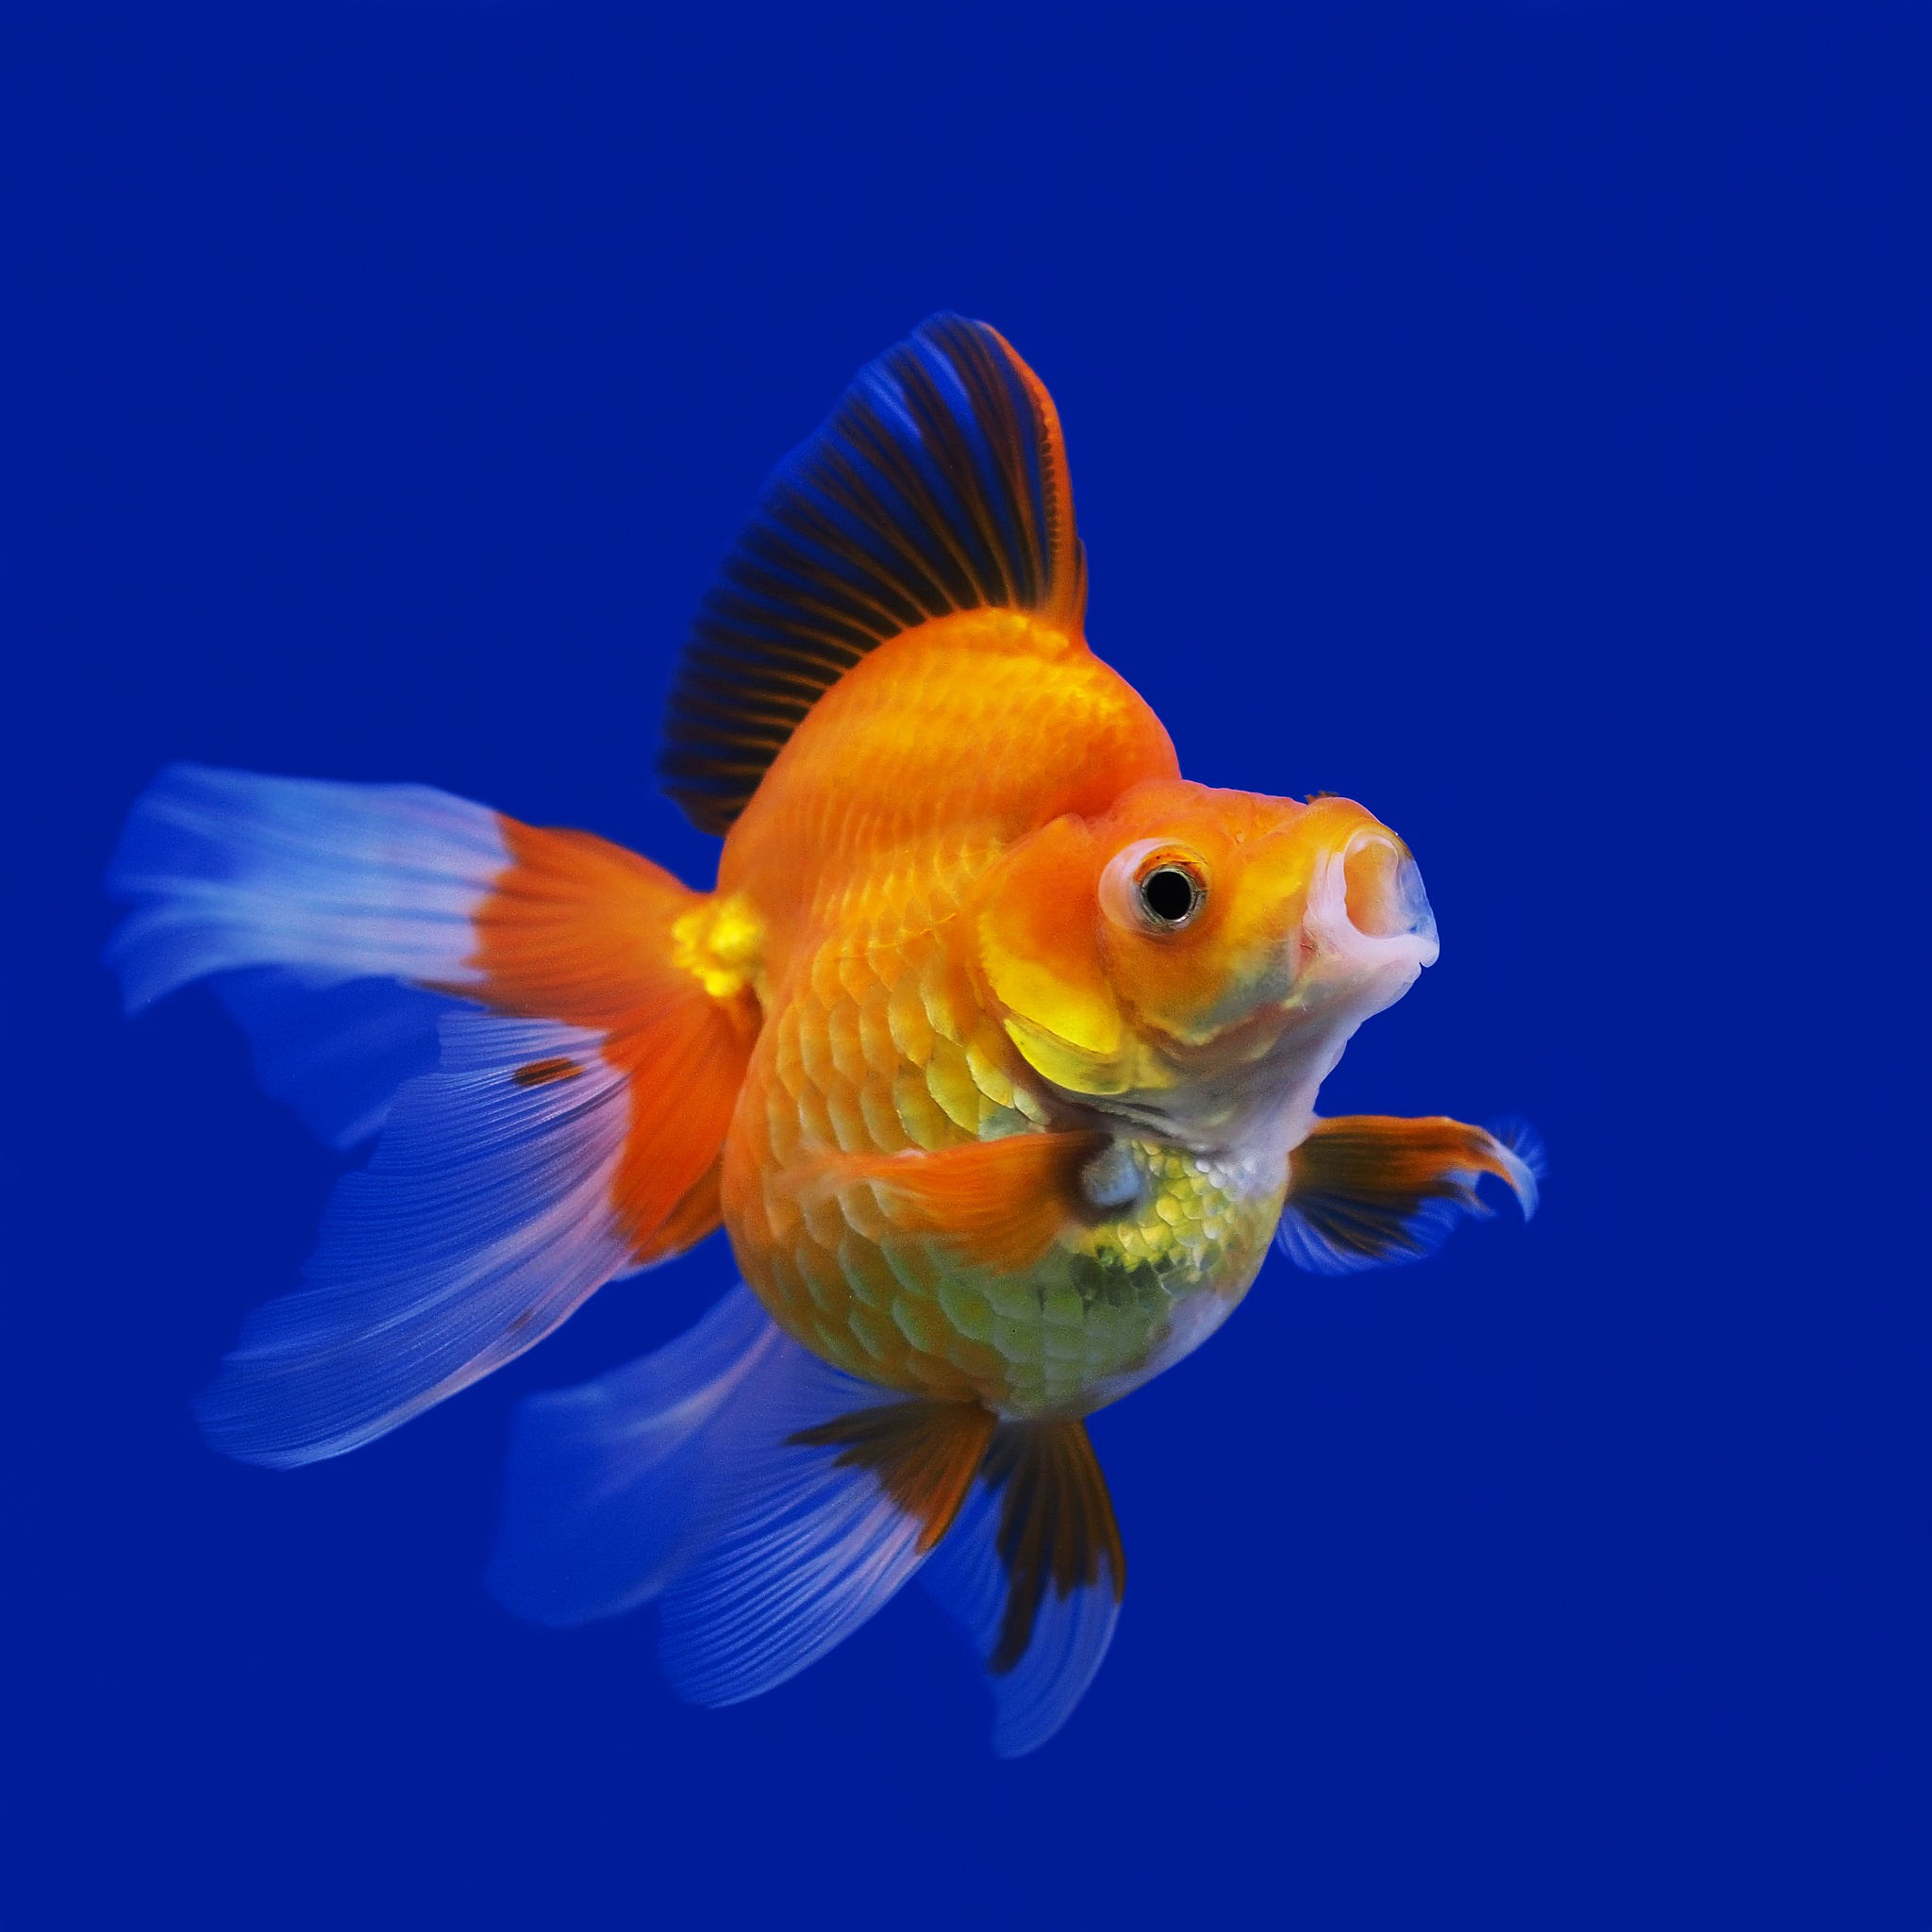

In [3]:
gold_fish=Image.open('licensed-image.jpg')
gold_fish

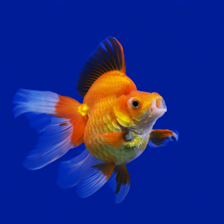

In [4]:
gold_fish=Image.open('licensed-image.jpg').resize((224,224))
gold_fish

In [5]:
gold_fish=np.array(gold_fish)/255.0
gold_fish.shape

(224, 224, 3)

In [6]:
gold_fish

array([[[0.        , 0.10980392, 0.59607843],
        [0.        , 0.10980392, 0.59607843],
        [0.        , 0.10980392, 0.59607843],
        ...,
        [0.        , 0.10980392, 0.59215686],
        [0.        , 0.10980392, 0.59607843],
        [0.        , 0.10980392, 0.59607843]],

       [[0.        , 0.10980392, 0.59215686],
        [0.        , 0.10980392, 0.59215686],
        [0.        , 0.10980392, 0.59215686],
        ...,
        [0.        , 0.10980392, 0.59215686],
        [0.        , 0.10980392, 0.59215686],
        [0.        , 0.10980392, 0.59215686]],

       [[0.        , 0.10980392, 0.58823529],
        [0.        , 0.10980392, 0.58823529],
        [0.        , 0.10588235, 0.58823529],
        ...,
        [0.        , 0.10980392, 0.58823529],
        [0.        , 0.10980392, 0.59215686],
        [0.        , 0.10980392, 0.59215686]],

       ...,

       [[0.        , 0.10980392, 0.59607843],
        [0.        , 0.10980392, 0.59215686],
        [0.        , 0

In [7]:
gold_fish[np.newaxis,...].shape

(1, 224, 224, 3)

In [8]:
result=classfication.predict(gold_fish[np.newaxis,...])

1/1 [==============================] - 1s 732ms/step


In [9]:
result.shape

(1, 1001)

In [10]:
predicted_lable_index=np.argmax(result)
predicted_lable_index

2

In [11]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

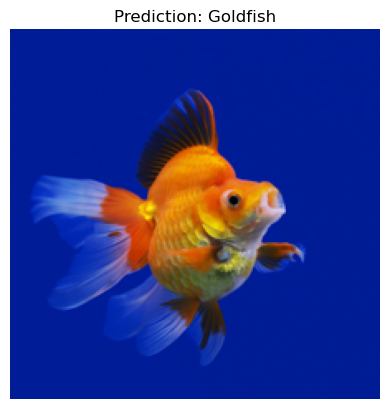

In [12]:
plt.imshow(gold_fish)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_lable_index]
_ = plt.title("Prediction: " + predicted_class_name.title())


In [13]:
batch_size = 32
img_height = 224
img_width = 224

dataset = tf.keras.utils.image_dataset_from_directory(
  "tumor",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  shuffle=True,
)

Found 3264 files belonging to 4 classes.


In [14]:
class_names = np.array(dataset.class_names)
print(class_names)

['glioma_tumor' 'meningioma_tumor' 'no_tumor' 'pituitary_tumor']


In [15]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    ds_size=len(ds)
    if shuffle :
        ds=ds.shuffle(shuffle_size,seed=12)
        
    train_size=int(ds_size*train_split)
    val_size=int(ds_size*val_split)

    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    
    return train_ds,val_ds,test_ds

In [16]:
train_ds,val_ds,test_ds=get_dataset_partitions_tf(dataset)

In [17]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)) 
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y)) 
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y)) 

In [18]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [19]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [20]:
result_batch = classfication.predict(train_ds)

81/81 [==============================] - 52s 628ms/step


In [21]:
predicted_class_names = imagenet_labels[tf.math.argmax(result_batch, axis=-1)]
predicted_class_names

array(['plastic bag', 'Petri dish', 'gong', ..., 'oxygen mask',
       'pickelhaube', 'steel drum'], dtype='<U30')

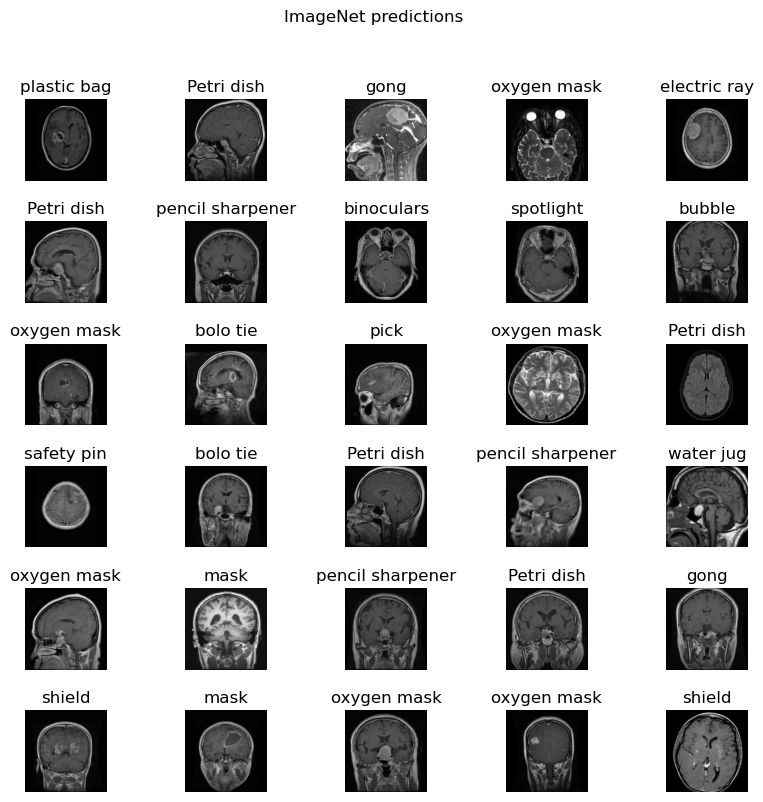

In [22]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")


In [23]:
mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
inception_v3 = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"

feature_extractor_model = mobilenet_v2

In [24]:
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(224, 224, 3),
    trainable=False)

In [25]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


In [26]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(num_classes)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 4)                 5124      
                                                                 
Total params: 2263108 (8.63 MB)
Trainable params: 5124 (20.02 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [27]:
predictions = model(image_batch)

In [28]:
predictions.shape

TensorShape([32, 4])

In [29]:
import datetime
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1) # Enable histogram computation for every epoch.

In [30]:
NUM_EPOCHS = 20

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=NUM_EPOCHS)

Epoch 1/20
81/81 [==============================] - 82s 969ms/step - loss: 0.8757 - acc: 0.6362 - val_loss: 0.5397 - val_acc: 0.8188
Epoch 2/20
81/81 [==============================] - 68s 843ms/step - loss: 0.5140 - acc: 0.8125 - val_loss: 0.4400 - val_acc: 0.8531
Epoch 3/20
81/81 [==============================] - 68s 841ms/step - loss: 0.4174 - acc: 0.8542 - val_loss: 0.3589 - val_acc: 0.8750
Epoch 4/20
81/81 [==============================] - 66s 812ms/step - loss: 0.3713 - acc: 0.8723 - val_loss: 0.3196 - val_acc: 0.8969
Epoch 5/20
81/81 [==============================] - 57s 701ms/step - loss: 0.3338 - acc: 0.8846 - val_loss: 0.2970 - val_acc: 0.9062
Epoch 6/20
81/81 [==============================] - 56s 696ms/step - loss: 0.2986 - acc: 0.9035 - val_loss: 0.2789 - val_acc: 0.9187
Epoch 7/20
81/81 [==============================] - 66s 818ms/step - loss: 0.2800 - acc: 0.9163 - val_loss: 0.2604 - val_acc: 0.9312
Epoch 8/20
81/81 [==============================] - 63s 777ms/step - 

In [31]:
acc=history.history['acc']
val_acc=history.history['val_acc']

loss=history.history['loss']
val_loss=history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Losses')

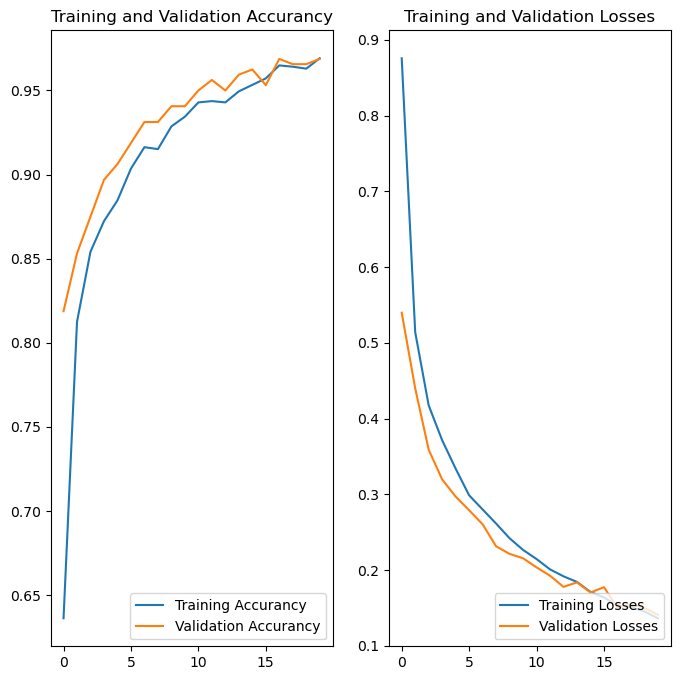

In [32]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(NUM_EPOCHS),acc,label='Training Accurancy')
plt.plot(range(NUM_EPOCHS),val_acc,label='Validation Accurancy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accurancy')

plt.subplot(1,2,2)
plt.plot(range(NUM_EPOCHS),loss,label='Training Losses')
plt.plot(range(NUM_EPOCHS),val_loss,label='Validation Losses')
plt.legend(loc='lower right')
plt.title('Training and Validation Losses')

In [33]:
predicted_batch = model.predict(image_batch)
predicted_id = tf.math.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]
print(predicted_label_batch)

1/1 [==============================] - 2s 2s/step
['glioma_tumor' 'pituitary_tumor' 'meningioma_tumor' 'no_tumor'
 'meningioma_tumor' 'pituitary_tumor' 'pituitary_tumor' 'pituitary_tumor'
 'pituitary_tumor' 'pituitary_tumor' 'glioma_tumor' 'glioma_tumor'
 'meningioma_tumor' 'no_tumor' 'no_tumor' 'glioma_tumor'
 'meningioma_tumor' 'pituitary_tumor' 'meningioma_tumor' 'pituitary_tumor'
 'pituitary_tumor' 'no_tumor' 'pituitary_tumor' 'pituitary_tumor'
 'pituitary_tumor' 'glioma_tumor' 'meningioma_tumor' 'pituitary_tumor'
 'glioma_tumor' 'no_tumor' 'glioma_tumor' 'no_tumor']


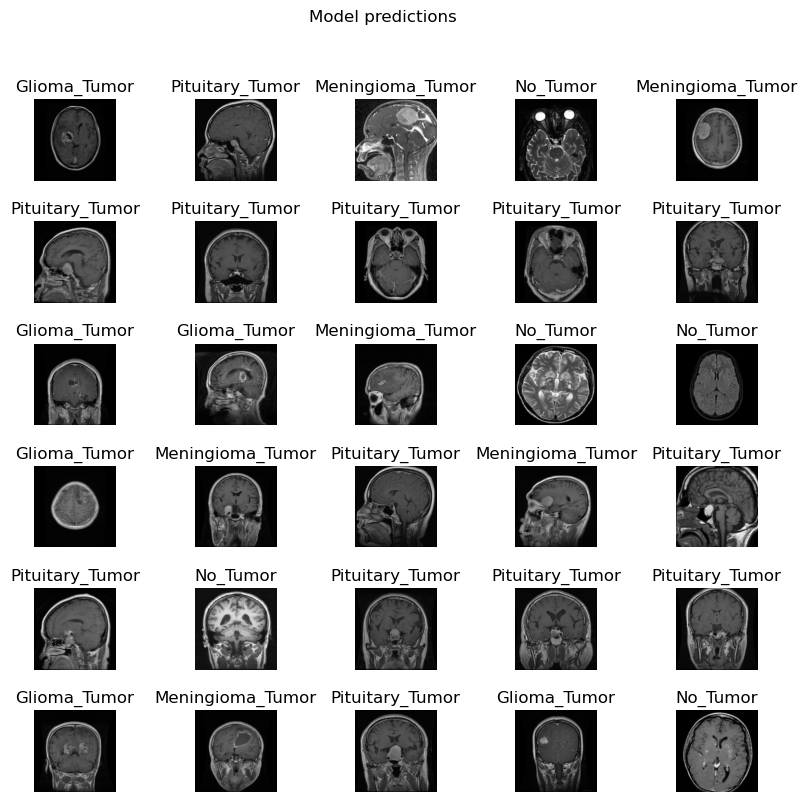

In [34]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)

for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_label_batch[n].title())
  plt.axis('off')
_ = plt.suptitle("Model predictions")

In [35]:
def predict(model,img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,axis=0)
    
    predications=model.predict(img_array)
    
    predicated_class=class_names[np.argmax(predications[0])]
    class_probabilities = tf.nn.softmax(predictions[0])
    confidence = round(100 * tf.reduce_max(class_probabilities).numpy(),2)

    return predicated_class,confidence

1/1 [==============================] - 0s 47ms/step


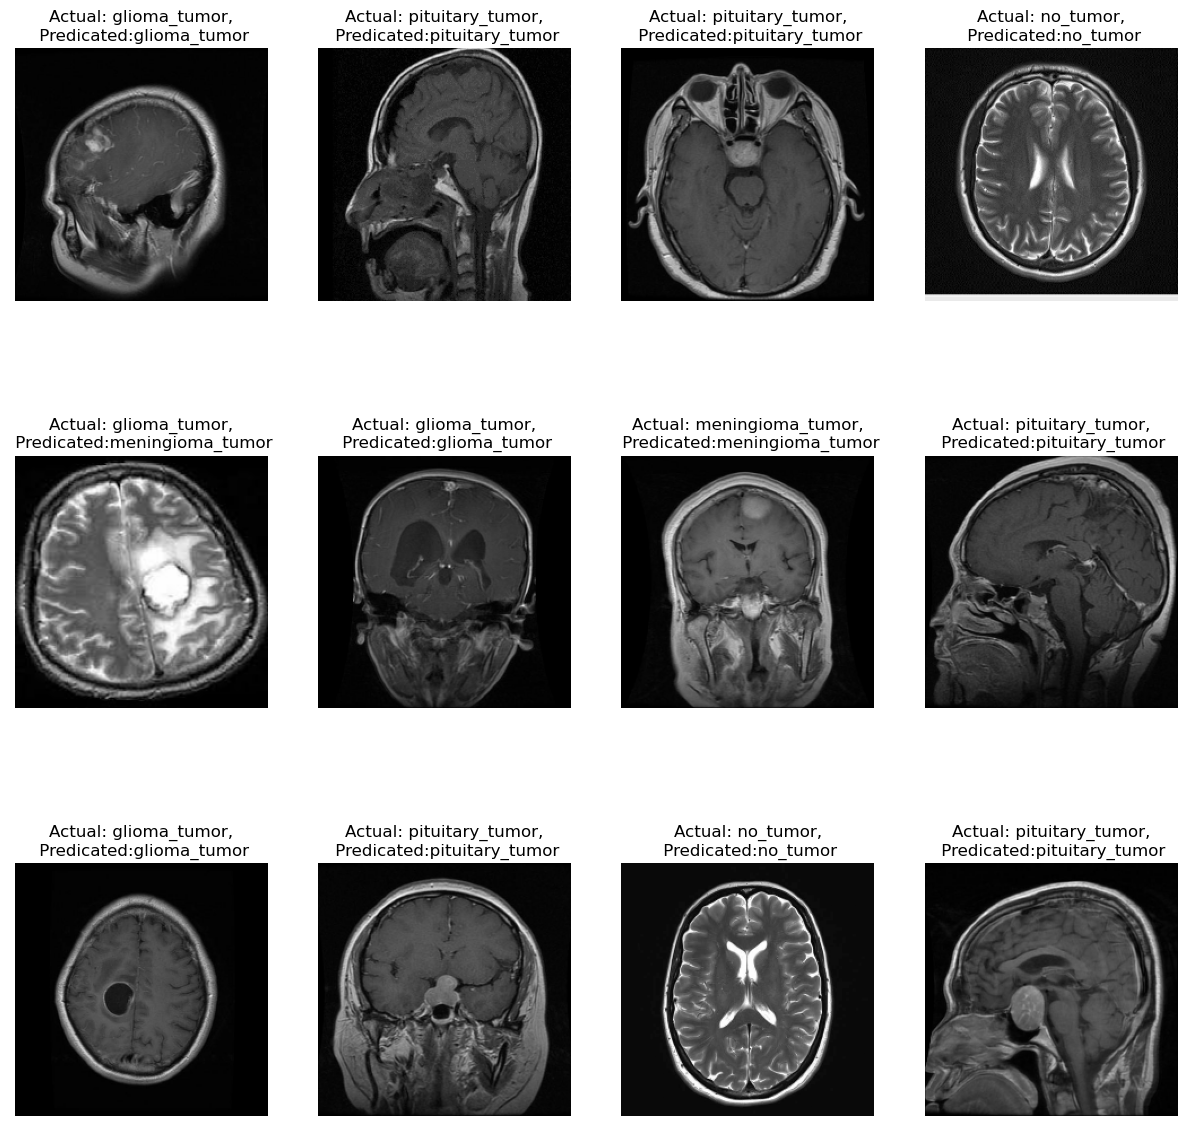

In [36]:
plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(images[i].numpy())
        actual_class=class_names[labels[i]]
        predication,confidence=predict(model,images[i].numpy())
        plt.title(f"Actual: {actual_class},\n Predicated:{predication}" )
        plt.axis('Off')

In [37]:
import os
model.save(f"transfer_models/1")

INFO:tensorflow:Assets written to: transfer_models/1\assets


INFO:tensorflow:Assets written to: transfer_models/1\assets
